In [7]:
import torch
import os
import time
import torch.nn as nn
from cell import graph_utils, utils
from cell.Word2vec import prepare_vocab, dataloader, wv
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk

os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
data_dir = "/Users/fahimehb/Documents/NPP_GNN_project/dat/"

In [9]:
walk_dir = "/Users/fahimehb/Documents/GNN/dat/walks/jsd/N_1_l_10000_p_1_q_1"

In [27]:
cl_df = pd.read_csv("/Users/fahimehb/Documents/GNN/dat/cl_df_150cl.csv", index_col="Unnamed: 0")
JSD = pd.read_csv(data_dir + "/jsd_python_recomputed.csv", index_col="Unnamed: 0")

In [28]:
JSD.head()

,L2/3 IT VISp Rrad,L2/3 IT VISp Adamts2,L2/3 IT VISp Agmat,L2/3 IT ALM Sla,L2/3 IT ALM Ptrf,L2/3 IT ALM Macc1 Lrg1,L4 IT VISp Rspo1,L5 IT VISp Hsd11b1 Endou,L5 IT VISp Whrn Tox2,L5 IT VISp Batf3,...,Pvalb Calb1 Sst,Pvalb Akr1c18 Ntf3,Pvalb Sema3e Kank4,Pvalb Gpr149 Islr,Pvalb Reln Itm2a,Pvalb Reln Tac1,Pvalb Tpbg,Pvalb Vipr2,Meis2 Adamts19,CR Lhx5
L2/3 IT VISp Rrad,0.000000,0.301102,0.298124,0.368229,0.380890,0.374299,0.443092,0.424371,0.451549,0.460754,...,0.652734,0.672896,0.681676,0.662296,0.670632,0.645035,0.642742,0.651381,0.931339,0.960910
L2/3 IT VISp Adamts2,0.301102,0.000000,0.188236,0.214161,0.270566,0.258561,0.400160,0.355376,0.366944,0.384346,...,0.594207,0.612206,0.620531,0.611896,0.613267,0.587671,0.586599,0.607065,0.926450,0.950134
L2/3 IT VISp Agmat,0.298124,0.188236,0.000000,0.226926,0.199509,0.200723,0.338924,0.310884,0.338887,0.349076,...,0.585534,0.599034,0.603322,0.595078,0.597362,0.577257,0.572084,0.596130,0.939060,0.964855
L2/3 IT ALM Sla,0.368229,0.214161,0.226926,0.000000,0.184497,0.175146,0.434578,0.367249,0.361779,0.396239,...,0.597412,0.607766,0.604308,0.614858,0.609763,0.595626,0.581946,0.616643,0.955213,0.983243
L2/3 IT ALM Ptrf,0.380890,0.270566,0.199509,0.184497,0.000000,0.184492,0.416107,0.355162,0.357739,0.377770,...,0.591342,0.600843,0.597574,0.601609,0.600725,0.587534,0.575117,0.603320,0.950286,0.986370


In [29]:
cl_df = cl_df.set_index("cluster_id")
cl_df.head()

,cluster_label,cluster_color,subclass_id,subclass_label,subclass_color,class_id,class_label,class_color,dendcluster_id,dendcluster_label,dendcluster_color,mu_x,mu_y
cluster_id,,,,,,,,,,,,,
61,L2/3 IT VISp Rrad,#D9F077,7,L2/3 IT,#94D9A1,2,Glutamatergic,#27AAE1,1.0,L2/3 IT VISp Rrad,#D9F077,0.155991,-0.443063
62,L2/3 IT VISp Adamts2,#A6E6A9,7,L2/3 IT,#94D9A1,2,Glutamatergic,#27AAE1,2.0,L2/3 IT VISp Adamts2,#A6E6A9,0.333016,-0.540455
63,L2/3 IT VISp Agmat,#7AE6AB,7,L2/3 IT,#94D9A1,2,Glutamatergic,#27AAE1,3.0,L2/3 IT VISp Agmat,#7AE6AB,0.323327,-0.576560
64,L2/3 IT ALM Sla,#82AD7D,7,L2/3 IT,#94D9A1,2,Glutamatergic,#27AAE1,4.0,L2/3 IT ALM Sla,#82AD7D,0.498074,-0.641736
65,L2/3 IT ALM Ptrf,#B8FFCA,7,L2/3 IT,#94D9A1,2,Glutamatergic,#27AAE1,5.0,L2/3 IT ALM Ptrf,#B8FFCA,0.481052,-0.634547


In [30]:
# types

In [31]:
types = JSD.index.tolist()
type_id = []

for t in types:
    type_id.append(str(cl_df[cl_df['cluster_label']==t].index.tolist()[0]))

In [32]:
JSD.columns = type_id
JSD.index = type_id

In [33]:
JSD.head()

,61,62,63,64,65,66,67,68,69,70,...,54,53,55,56,58,57,59,60,116,117
61,0.000000,0.301102,0.298124,0.368229,0.380890,0.374299,0.443092,0.424371,0.451549,0.460754,...,0.652734,0.672896,0.681676,0.662296,0.670632,0.645035,0.642742,0.651381,0.931339,0.960910
62,0.301102,0.000000,0.188236,0.214161,0.270566,0.258561,0.400160,0.355376,0.366944,0.384346,...,0.594207,0.612206,0.620531,0.611896,0.613267,0.587671,0.586599,0.607065,0.926450,0.950134
63,0.298124,0.188236,0.000000,0.226926,0.199509,0.200723,0.338924,0.310884,0.338887,0.349076,...,0.585534,0.599034,0.603322,0.595078,0.597362,0.577257,0.572084,0.596130,0.939060,0.964855
64,0.368229,0.214161,0.226926,0.000000,0.184497,0.175146,0.434578,0.367249,0.361779,0.396239,...,0.597412,0.607766,0.604308,0.614858,0.609763,0.595626,0.581946,0.616643,0.955213,0.983243
65,0.380890,0.270566,0.199509,0.184497,0.000000,0.184492,0.416107,0.355162,0.357739,0.377770,...,0.591342,0.600843,0.597574,0.601609,0.600725,0.587534,0.575117,0.603320,0.950286,0.986370


In [34]:
edge_list = graph_utils.build_edge_list(weight_matrix=JSD, threshold=0, directed=False)

Upper triangle and diag are used as weights


In [35]:
nxg = graph_utils.build_nx_graph(source_target_weight=edge_list, directed=False)

In [37]:
rw = BiasedRandomWalk(sg)

In [14]:
# nodes = list(sg.nodes())

# walks = rw.run(nodes,
#                length=10000,
#                n=1,
#                p=1,         
#                q=1,         
#                weighted=True)

In [16]:
# utils.write_list_of_lists_to_csv(walk_dir, "walk_0.csv", walks)

In [38]:
walks = utils.read_list_of_lists_from_csv(os.path.join(walk_dir, "walk_0.csv"))

In [39]:
vocabulary = prepare_vocab.get_vocabulary(walks)

print(f'lenght of vocabulary: {len(vocabulary)}')

word_2_index = prepare_vocab.get_word2idx(vocabulary, padding=True)
index_2_word = prepare_vocab.get_idx2word(vocabulary, padding=True)

lenght of vocabulary: 117
a node called pad is added for padding and its index is zero
a node called pad is added for padding and its index is zero


In [40]:
context_tuple_list = prepare_vocab.MCBOW_get_word_context_tuples(walks, window=2)

MCBOW by default adds a padding node called pad with index zero
There are 1170000 pairs of target and context words


In [41]:
dataset = dataloader.MCBOW_WalkDataset(context_tuple_list, word_2_index)

data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                          batch_size=2000, 
                                          shuffle=True,
                                          num_workers=1)

In [42]:
vocab_size = len(vocabulary) + 1
embedding_size = 2
learning_rate = 0.001
n_epochs = 50

In [43]:
criterion = nn.CrossEntropyLoss()

model = wv.MCBOW_Word2Vec(embedding_size=embedding_size, vocab_size=vocab_size)

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
n_total_steps = len(data_loader)

training_loss = []


for epoch in range(n_epochs):
    t0 = time.time()
    losses = []
    for i, (target, context) in enumerate(data_loader):
        target = target.to(device)
        context = context.to(device)
        prediction = model(context)
        loss = criterion(prediction, target)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    t1 = time.time()
    #print('time is %.2f' % (t1 - t0))
        
    training_loss.append(np.mean(losses)) 
    print(f'epoch: {epoch+1}/{n_epochs}, loss:{np.mean(losses):.4f}')

the index2word and word2index dicts must have padding with index zero
epoch: 1/50, loss:4.8339
epoch: 2/50, loss:4.7708
epoch: 3/50, loss:4.7601
epoch: 4/50, loss:4.7569
epoch: 5/50, loss:4.7543
epoch: 6/50, loss:4.7510
epoch: 7/50, loss:4.7474
epoch: 8/50, loss:4.7446
epoch: 9/50, loss:4.7429
epoch: 10/50, loss:4.7418
epoch: 11/50, loss:4.7410
epoch: 12/50, loss:4.7403
epoch: 13/50, loss:4.7399
epoch: 14/50, loss:4.7396
epoch: 15/50, loss:4.7394
epoch: 16/50, loss:4.7393
epoch: 17/50, loss:4.7392
epoch: 18/50, loss:4.7391
epoch: 19/50, loss:4.7391
epoch: 20/50, loss:4.7391
epoch: 21/50, loss:4.7391
epoch: 22/50, loss:4.7391
epoch: 23/50, loss:4.7390
epoch: 24/50, loss:4.7390
epoch: 25/50, loss:4.7390
epoch: 26/50, loss:4.7390
epoch: 27/50, loss:4.7390
epoch: 28/50, loss:4.7390
epoch: 29/50, loss:4.7390
epoch: 30/50, loss:4.7390
epoch: 31/50, loss:4.7390
epoch: 32/50, loss:4.7390
epoch: 33/50, loss:4.7390
epoch: 34/50, loss:4.7390
epoch: 35/50, loss:4.7390
epoch: 36/50, loss:4.7390
epo

In [45]:
from cell import analysis, plot_utils
%matplotlib qt5
#cldf = utils.read_visp_npp_cldf()
vectors = model.embeddings.weight.detach().numpy()
data = analysis.summarize_walk_embedding_results(gensim_dict={"model": vectors},
                                                 index = index_2_word.values(),
                                                 ndim=2, 
                                                 cl_df=cl_df,
                                                padding_label="pad")

fig= plot_utils.plot_embedding(data=data, 
#                           cl_df=cl_df,
                          plot_dim=2, 
                          plot_size=(10,10), 
                          annotation=False)


In [47]:
# data

In [37]:
data.to_csv("/Users/fahimehb/Documents/GNN/dat/jsd_results/wv_2d.csv")

In [31]:
fig.savefig("/Users/fahimehb/Documents/GNN/dat/jsd_results/wv_3d.png", dpi=750)

In [55]:
cl_df.loc['32']

cluster_label        Sst Tac1 Htr1d
cluster_color               #804811
subclass_id                       5
subclass_label                  Sst
subclass_color              #F15A29
class_id                          1
class_label               GABAergic
class_color                 #EF4136
dendcluster_id                   87
dendcluster_label    Sst Tac1 Htr1d
dendcluster_color           #804811
mu_x                      -0.209201
mu_y                        1.00029
Name: 32, dtype: object

In [33]:
data.to_csv("/Users/fahimehb/Documents/GNN/dat/jsd_results/wv_3d.csv")

In [36]:
data_2d = pd.read_csv("/Users/fahimehb/Documents/GNN/dat/jsd_results/wv_2d.csv", index_col="cluster_id")

In [37]:
data_2d

,Z0,Z1,cluster_label,cluster_color,subclass_id,subclass_label,subclass_color,class_id,class_label,class_color,dendcluster_id,dendcluster_label,dendcluster_color,mu_x,mu_y,channel_id
cluster_id,,,,,,,,,,,,,,,,
67,0.259599,0.711928,L4 IT VISp Rspo1,#00979D,8,L4,#00979D,2,Glutamatergic,#27AAE1,7.0,L4 IT VISp Rspo1,#00979D,0.157901,-1.324128,model
6,-0.657584,-0.287118,Lamp5 Lsp1,#FFA388,1,Lamp5,#DA808C,1,GABAergic,#EF4136,61.0,Lamp5 Lsp1,#FFA388,-1.176295,1.344544,model
112,-0.267619,0.571770,L6b ALM Olfr111 Nxph1,#494566,14,L6b,#25596D,2,Glutamatergic,#27AAE1,52.0,L6b ALM Olfr111 Nxph1,#494566,1.371109,0.596923,model
44,-1.766244,-0.181984,Sst Crhr2 Efemp1,#B95541,5,Sst,#F15A29,1,GABAergic,#EF4136,99.0,Sst Crhr2 Efemp1,#B95541,-0.196240,1.252715,model
110,-0.105616,0.811550,L6b VISp Col8a1 Rxfp1,#388899,14,L6b,#25596D,2,Glutamatergic,#27AAE1,50.0,L6b VISp Col8a1 Rxfp1,#388899,1.359733,0.396464,model
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,-0.452352,0.662774,L6b Hsd17b2,#335280,14,L6b,#25596D,2,Glutamatergic,#27AAE1,55.0,L6b Hsd17b2,#335280,1.426455,0.582969,model
23,0.296526,-1.207520,Vip Lect1 Oxtr,#FF00B3,4,Vip,#70559A,1,GABAergic,#EF4136,78.0,Vip Lect1 Oxtr,#FF00B3,-1.486227,0.146654,model
64,0.158458,1.167883,L2/3 IT ALM Sla,#82AD7D,7,L2/3 IT,#94D9A1,2,Glutamatergic,#27AAE1,4.0,L2/3 IT ALM Sla,#82AD7D,0.498074,-0.641736,model


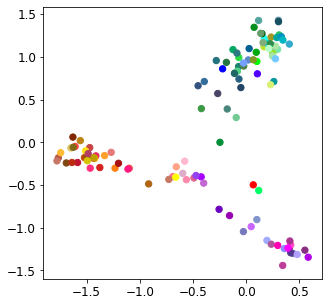

In [41]:
%matplotlib inline
fig= plot_utils.plot_embedding(data=data_2d, 
#                           cl_df=cl_df,
                          plot_dim=2, 
                          plot_size=(5,5), 
                          annotation=False)

In [42]:
fig.savefig("/Users/fahimehb/Documents/GNN/dat/jsd_results/wv_2d.png", dpi=750)

### Procrustes analysis

In [ ]:
pd.read_csv